In [1]:
from pyomo.environ import *
import matplotlib.pyplot as plt
import pandas as pd

ε =   0 → Cost = $1.57M
ε =  50 → Cost = $20.63M
ε = 100 → Infeasible
ε = 150 → Infeasible
ε = 200 → Infeasible
ε = 250 → Infeasible
ε = 300 → Infeasible
ε = 350 → Infeasible
ε = 400 → Infeasible
ε = 450 → Infeasible
ε = 500 → Infeasible
ε = 550 → Infeasible
ε = 600 → Infeasible
ε = 650 → Infeasible
ε = 700 → Infeasible
ε = 750 → Infeasible


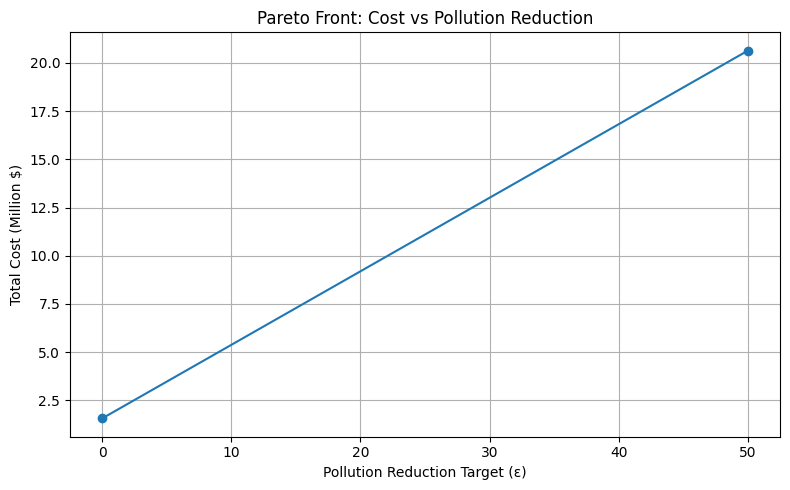

In [2]:
# ---------------------
# Model Setup
# ---------------------
def build_model(epsilon_pm, epsilon_nh3, budget_limit=10):
    model = ConcreteModel()

    # Sets
    model.sources = RangeSet(1, 4)
    model.controls = RangeSet(1, 9)
    model.pollutants = Set(initialize=['PM', 'NH3'])

    # Source-control compatibility
    compatible = {
        1: [1, 2, 3, 4],
        2: [5, 6],
        3: [7, 8],
        4: [9],
    }

    model.Iij = Set(dimen=2, initialize=[(i, j) for i in compatible for j in compatible[i]])

    # Parameters
    c_ij = {(1,1):1.0, (1,2):1.0, (1,3):0.95, (1,4):1.2,
            (2,5):1.0, (2,6):0.85,
            (3,7):0.1, (3,8):0.2,
            (4,9):0.2}

    R_ijk = { (1,1,'PM'):0.95, (1,2,'PM'):0.92, (1,3,'PM'):0.93, (1,4,'PM'):0.99,
        (2,5,'PM'):0.99, (2,6,'PM'):0.95,
        (3,7,'PM'):0.98, (3,8,'PM'):0.97,
        (4,9,'PM'):0.99,
        (1,1,'NH3'):0.4, (1,2,'NH3'):0.4, (1,3,'NH3'):0.4, (1,4,'NH3'):0.4,
        (2,5,'NH3'):1.0, (2,6,'NH3'):1.0,
        (3,7,'NH3'):0.03, (3,8,'NH3'):0.03,
        (4,9,'NH3'):0.0}

    a = {1:0.0357, 2:0.0667, 3:0.0300, 4:0.0875,
         5:0.0571, 6:0.0357, 7:0.0438, 8:0.0333, 9:0.0278}

    b = {1:0.721, 2:0.833, 3:0.620, 4:0.850,
         5:0.771, 6:0.721, 7:0.825, 8:0.733, 9:0.678}

    T_max = 18

    # Decision Variables
    model.x = Var(model.Iij, domain=Binary)
    model.T = Var(model.controls, bounds=(0, T_max))
    model.Tij = Var(model.Iij, bounds=(0, T_max))

    # Objective: Minimize total cost
    def cost_rule(model):
        op_cost = sum(c_ij[i, j] * model.Tij[i, j] for (i, j) in model.Iij)
        inv_cost = sum(a[j] * model.T[j] + b[j] * sum(model.x[i, j] for i in compatible if (i, j) in model.Iij)
                       for j in model.controls)
        return op_cost + inv_cost

    model.TotalCost = Objective(rule=cost_rule, sense=minimize)

    # Constraint: One control per source
    def one_control_per_source(model, i):
        return sum(model.x[i, j] for j in compatible[i]) <= 1
    model.OneControl = Constraint(model.sources, rule=one_control_per_source)

    # Link Tij and xij
    def link_Tij_xij(model, i, j):
        return model.Tij[i, j] <= T_max * model.x[i, j]
    model.Link = Constraint(model.Iij, rule=link_Tij_xij)

    # ε-constraint: Pollution reduction requirement
    def pm_reduction(model):
        return sum(R_ijk[i,j,'PM'] * model.Tij[i,j] for (i,j) in model.Iij if (i,j,'PM') in R_ijk) >= epsilon_pm
    model.PMReduction = Constraint(rule=pm_reduction)

    def nh3_reduction(model):
        return sum(R_ijk[i,j,'NH3'] * model.Tij[i,j] for (i,j) in model.Iij if (i,j,'NH3') in R_ijk) >= epsilon_nh3
    model.NH3Reduction = Constraint(rule=nh3_reduction)

    def budget_constraint(model):
        return sum((a[j] + b[j]) * model.x[i,j] for (i,j) in model.Iij) <= budget_limit
    model.Budget = Constraint(rule=budget_constraint)

    return model

# ---------------------
# Pareto Frontier Generation
# ---------------------
# Example usage with fixed PM and NH3 reduction targets

results = []
epsilons = list(range(0, 751, 50))  # 0 to 750 in steps

for eps in epsilons:
    model = build_model(epsilon_pm=eps, epsilon_nh3=1.0)
    result = SolverFactory('glpk').solve(model, tee=False)

    if result.solver.status == SolverStatus.ok and result.solver.termination_condition == TerminationCondition.optimal:
        cost = value(model.TotalCost)
        results.append((eps, cost))
        print(f"ε = {eps:3d} → Cost = ${cost:.2f}M")
    else:
        print(f"ε = {eps:3d} → Infeasible")
        results.append((eps, None))

# ---------------------
# Plotting
# ---------------------
eps_vals = [r[0] for r in results if r[1] is not None]
cost_vals = [r[1] for r in results if r[1] is not None]

plt.figure(figsize=(8, 5))
plt.plot(eps_vals, cost_vals, marker='o')
plt.title("Pareto Front: Cost vs Pollution Reduction")
plt.xlabel("Pollution Reduction Target (ε)")
plt.ylabel("Total Cost (Million $)")
plt.grid(True)
plt.tight_layout()
plt.show()


In [3]:
# ---------------------
# Results Analysis and Output
# ---------------------

# Analyze a specific solution (e.g., the last one or a chosen epsilon)
chosen_epsilon = epsilons[-1]  # Or any epsilon you want to analyze
model = build_model(epsilon_pm=chosen_epsilon, epsilon_nh3=1.0)
solver_result = SolverFactory('glpk', executable='/usr/bin/glpsol').solve(model, tee=True)

if solver_result.solver.status == SolverStatus.ok and solver_result.solver.termination_condition == TerminationCondition.optimal:
    result_data = []
    for (i, j) in model.Iij:
        if value(model.x[i, j]) > 0.5:  # Check if control is selected
            result_data.append({
                "Source": i,
                "Control Option": j,
                "PM Reduction": R_ijk.get((i, j, 'PM'), float('nan')),
                "NH3 Reduction": R_ijk.get((i, j, 'NH3'), float('nan')),
                "Investment Cost": a.get(j, float('nan')),
                "Operating Cost": b.get(j, float('nan'))
            })

    df_result = pd.DataFrame(result_data)
    df_result["Total Cost"] = df_result["Investment Cost"] + df_result["Operating Cost"]
    print("\n--- Analysis for epsilon_pm =", chosen_epsilon, "---")
    print(df_result)

    # --- Optional: Save results to a CSV file ---
    csv_filename = f"pollution_control_results_eps_{chosen_epsilon}.csv"
    df_result.to_csv(csv_filename, index=False)
    print(f"\nResults saved to {csv_filename}")

else:
    print("\nSolver did not find an optimal solution for epsilon_pm =", chosen_epsilon)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmp1dz81_um.glpk.raw --wglp /tmp/tmp4xwwi0r0.glpk.glp --cpxlp
 /tmp/tmp9lxo2khe.pyomo.lp
Reading problem data from '/tmp/tmp9lxo2khe.pyomo.lp'...
/tmp/tmp9lxo2khe.pyomo.lp:165: warning: lower bound of variable 'x20' redefined
/tmp/tmp9lxo2khe.pyomo.lp:165: warning: upper bound of variable 'x20' redefined
16 rows, 27 columns, 53 non-zeros
9 integer variables, all of which are binary
174 lines were read
Writing problem data to '/tmp/tmp4xwwi0r0.glpk.glp'...
160 lines were written
GLPK Integer Optimizer 5.0
16 rows, 27 columns, 53 non-zeros
9 integer variables, all of which are binary
Preprocessing...
PROBLEM HAS NO PRIMAL FEASIBLE SOLUTION
Time used:   0.0 secs
Memory used: 0.0 Mb (47725 bytes)
Writing MIP solution to '/tmp/tmp1dz81_um.glpk.raw'...
52 lines were written

Solver did not find an optimal solution for epsilon_pm = 750


In [4]:
from pyomo.util.infeasible import log_infeasible_constraints
log_infeasible_constraints(model)

level is higher than logging.INFO: no output will be logged regardless of
constraint feasibility


In [5]:
SolverFactory('glpk').solve(model, tee=True)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmpv8qps6kv.glpk.raw --wglp /tmp/tmpdpat_b9j.glpk.glp --cpxlp
 /tmp/tmpwqhy3o74.pyomo.lp
Reading problem data from '/tmp/tmpwqhy3o74.pyomo.lp'...
/tmp/tmpwqhy3o74.pyomo.lp:165: warning: lower bound of variable 'x20' redefined
/tmp/tmpwqhy3o74.pyomo.lp:165: warning: upper bound of variable 'x20' redefined
16 rows, 27 columns, 53 non-zeros
9 integer variables, all of which are binary
174 lines were read
Writing problem data to '/tmp/tmpdpat_b9j.glpk.glp'...
160 lines were written
GLPK Integer Optimizer 5.0
16 rows, 27 columns, 53 non-zeros
9 integer variables, all of which are binary
Preprocessing...
PROBLEM HAS NO PRIMAL FEASIBLE SOLUTION
Time used:   0.0 secs
Memory used: 0.0 Mb (47725 bytes)
Writing MIP solution to '/tmp/tmpv8qps6kv.glpk.raw'...
52 lines were written


{'Problem': [{'Name': 'unknown', 'Lower bound': -inf, 'Upper bound': inf, 'Number of objectives': 1, 'Number of constraints': 16, 'Number of variables': 27, 'Number of nonzeros': 53, 'Sense': 'minimize'}], 'Solver': [{'Status': 'ok', 'Termination condition': 'infeasible', 'Statistics': {'Branch and bound': {'Number of bounded subproblems': 0, 'Number of created subproblems': 0}}, 'Error rc': 0, 'Time': 0.002242565155029297}]}

In [6]:
results = SolverFactory('glpk').solve(model, tee=True)
print("Solver Status:", results.solver.status)
print("Termination Condition:", results.solver.termination_condition)

GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmp1ys63ny3.glpk.raw --wglp /tmp/tmp9k8gr54p.glpk.glp --cpxlp
 /tmp/tmpb1uhyje7.pyomo.lp
Reading problem data from '/tmp/tmpb1uhyje7.pyomo.lp'...
/tmp/tmpb1uhyje7.pyomo.lp:165: warning: lower bound of variable 'x20' redefined
/tmp/tmpb1uhyje7.pyomo.lp:165: warning: upper bound of variable 'x20' redefined
16 rows, 27 columns, 53 non-zeros
9 integer variables, all of which are binary
174 lines were read
Writing problem data to '/tmp/tmp9k8gr54p.glpk.glp'...
160 lines were written
GLPK Integer Optimizer 5.0
16 rows, 27 columns, 53 non-zeros
9 integer variables, all of which are binary
Preprocessing...
PROBLEM HAS NO PRIMAL FEASIBLE SOLUTION
Time used:   0.0 secs
Memory used: 0.0 Mb (47725 bytes)
Writing MIP solution to '/tmp/tmp1ys63ny3.glpk.raw'...
52 lines were written
Solver Status: ok
Termination Condition: infeasible


In [7]:
model.pprint()


2 Set Declarations
    Iij : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :    9 : {(1, 1), (1, 2), (1, 3), (1, 4), (2, 5), (2, 6), (3, 7), (3, 8), (4, 9)}
    pollutants : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'PM', 'NH3'}

2 RangeSet Declarations
    controls : Dimen=1, Size=9, Bounds=(1, 9)
        Key  : Finite : Members
        None :   True :   [1:9]
    sources : Dimen=1, Size=4, Bounds=(1, 4)
        Key  : Finite : Members
        None :   True :   [1:4]

3 Var Declarations
    T : Size=9, Index=controls
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :  None :    18 : False :  True :  Reals
          2 :     0 :  None :    18 : False :  True :  Reals
          3 :     0 :  None :    18 : False :  True :  Reals
          4 :     0 :  None :    18 : False :  True :  Reals
          5 :     0

In [8]:
# ---------------------
# Model Setup
# ---------------------
def build_mo_model(epsilon_pm, epsilon_nh3, budget_limit=10,
                    alpha=0.5, epsilon_pollution_reduction=None):


    model = ConcreteModel()

    # Sets
    model.sources = RangeSet(1, 4)
    model.controls = RangeSet(1, 9)
    model.pollutants = Set(initialize=['PM', 'NH3'])

    # Source-control compatibility
    compatible = {
        1: [1, 2, 3, 4],
        2: [5, 6],
        3: [7, 8],
        4: [9],
    }
    model.Iij = Set(dimen=2, initialize=[(i, j) for i in compatible for j in compatible[i]])

    # Parameters
    c_ij = {(1, 1): 1.0, (1, 2): 1.0, (1, 3): 0.95, (1, 4): 1.2,
            (2, 5): 1.0, (2, 6): 0.85,
            (3, 7): 0.1, (3, 8): 0.2,
            (4, 9): 0.2}

    R_ijk = {(1, 1, 'PM'): 0.95, (1, 2, 'PM'): 0.92, (1, 3, 'PM'): 0.93, (1, 4, 'PM'): 0.99,
             (2, 5, 'PM'): 0.99, (2, 6, 'PM'): 0.95,
             (3, 7, 'PM'): 0.98, (3, 8, 'PM'): 0.97,
             (4, 9, 'PM'): 0.99,
             (1, 1, 'NH3'): 0.4, (1, 2, 'NH3'): 0.4, (1, 3, 'NH3'): 0.4, (1, 4, 'NH3'): 0.4,
             (2, 5, 'NH3'): 1.0, (2, 6, 'NH3'): 1.0,
             (3, 7, 'NH3'): 0.03, (3, 8, 'NH3'): 0.03,
             (4, 9, 'NH3'): 0.0}

    a = {1: 0.0357, 2: 0.0667, 3: 0.0300, 4: 0.0875,
         5: 0.0571, 6: 0.0357, 7: 0.0438, 8: 0.0333, 9: 0.0278}

    b = {1: 0.721, 2: 0.833, 3: 0.620, 4: 0.850,
         5: 0.771, 6: 0.721, 7: 0.825, 8: 0.733, 9: 0.678}

    T_max = 18

    # Decision Variables
    model.x = Var(model.Iij, domain=Binary)
    model.T = Var(model.controls, bounds=(0, T_max))
    model.Tij = Var(model.Iij, bounds=(0, T_max))

    # Objective 1: Minimize Total Cost
    def cost_rule(model):
        return sum(c_ij[i, j] * model.Tij[i, j] for (i, j) in model.Iij) + \
               sum(a[j] * model.T[j] + b[j] * sum(model.x[i, j] for i in compatible if (i, j) in model.Iij)
                   for j in model.controls)
    model.TotalCost = Objective(rule=cost_rule, sense=minimize)

    # Objective 2: Maximize Total Pollution Reduction
    def pollution_reduction_rule(model):
        return sum(R_ijk[i, j, k] * model.Tij[i, j] for (i, j, k) in R_ijk)
    # Remove deactivate=True from here
    model.TotalPollutionReduction = Objective(rule=pollution_reduction_rule, sense=maximize)


    # Constraints
    def one_control_per_source(model, i):
        return sum(model.x[i, j] for j in compatible[i]) <= 1
    model.OneControl = Constraint(model.sources, rule=one_control_per_source)

    def link_Tij_xij(model, i, j):
        return model.Tij[i, j] <= T_max * model.x[i, j]
    model.Link = Constraint(model.Iij, rule=link_Tij_xij)

    def pm_reduction_constraint(model):
        return sum(R_ijk[i, j, 'PM'] * model.Tij[i, j] for (i, j) in model.Iij if (i, j, 'PM') in R_ijk) >= epsilon_pm
    model.PMReduction = Constraint(rule=pm_reduction_constraint)

    def nh3_reduction_constraint(model):
        return sum(R_ijk[i, j, 'NH3'] * model.Tij[i, j] for (i, j) in model.Iij if (i, j, 'NH3') in R_ijk) >= epsilon_nh3
    model.NH3Reduction = Constraint(rule=nh3_reduction_constraint)

    def budget_constraint(model):
        return sum((a[j] + b[j]) * sum(model.x[i, j] for i in compatible if (i, j) in model.Iij) for j in model.controls) <= budget_limit
    model.Budget = Constraint(rule=budget_constraint)

    # Multi-Objective Handling
    if epsilon_pollution_reduction is None:  # Weighted Sum Method
        # Deactivate individual objectives, activate weighted sum objective
        model.TotalCost.deactivate()
        model.TotalPollutionReduction.deactivate()
        def weighted_sum_objective_rule(model):
            return alpha * model.TotalCost - (1 - alpha) * model.TotalPollutionReduction
        model.WeightedSumObjective = Objective(rule=weighted_sum_objective_rule, sense=minimize)
    else:  # Epsilon-Constraint Method
        model.TotalCost.activate()  # Primary objective
        model.TotalPollutionReduction.deactivate()
        def epsilon_constraint_rule(model):
            return model.TotalPollutionReduction >= epsilon_pollution_reduction
        model.EpsilonConstraint = Constraint(rule=epsilon_constraint_rule)

    return model

# Solve and report results
model = build_model(epsilon_pm=3.5, epsilon_nh3=1.0, budget_limit=10)
results = SolverFactory('glpk', executable='/usr/bin/glpsol').solve(model, tee=True)

if results.solver.termination_condition == TerminationCondition.optimal:
    print("  Optimal solution found. Selected controls:")
    for (i, j) in model.Iij:
        if value(model.x[i, j]) > 0.5:
            print(f"  Source {i} → Control {j}, Time: {value(model.Tij[i, j]):.2f}")
else:
    print(" No optimal solution found. Try relaxing constraints or reviewing input data.")



GLPSOL--GLPK LP/MIP Solver 5.0
Parameter(s) specified in the command line:
 --write /tmp/tmp7rvk6vv5.glpk.raw --wglp /tmp/tmpnbe5eil9.glpk.glp --cpxlp
 /tmp/tmpganqcciy.pyomo.lp
Reading problem data from '/tmp/tmpganqcciy.pyomo.lp'...
/tmp/tmpganqcciy.pyomo.lp:165: warning: lower bound of variable 'x20' redefined
/tmp/tmpganqcciy.pyomo.lp:165: warning: upper bound of variable 'x20' redefined
16 rows, 27 columns, 53 non-zeros
9 integer variables, all of which are binary
174 lines were read
Writing problem data to '/tmp/tmpnbe5eil9.glpk.glp'...
160 lines were written
GLPK Integer Optimizer 5.0
16 rows, 27 columns, 53 non-zeros
9 integer variables, all of which are binary
Preprocessing...
14 rows, 18 columns, 43 non-zeros
9 integer variables, all of which are binary
Scaling...
 A: min|aij| =  3.000e-02  max|aij| =  1.800e+01  ratio =  6.000e+02
GM: min|aij| =  4.130e-01  max|aij| =  2.422e+00  ratio =  5.864e+00
EQ: min|aij| =  1.705e-01  max|aij| =  1.000e+00  ratio =  5.864e+00
2N: min|

In [9]:
model.pprint()

2 Set Declarations
    Iij : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     2 :    Any :    9 : {(1, 1), (1, 2), (1, 3), (1, 4), (2, 5), (2, 6), (3, 7), (3, 8), (4, 9)}
    pollutants : Size=1, Index=None, Ordered=Insertion
        Key  : Dimen : Domain : Size : Members
        None :     1 :    Any :    2 : {'PM', 'NH3'}

2 RangeSet Declarations
    controls : Dimen=1, Size=9, Bounds=(1, 9)
        Key  : Finite : Members
        None :   True :   [1:9]
    sources : Dimen=1, Size=4, Bounds=(1, 4)
        Key  : Finite : Members
        None :   True :   [1:4]

3 Var Declarations
    T : Size=9, Index=controls
        Key : Lower : Value : Upper : Fixed : Stale : Domain
          1 :     0 :   0.0 :    18 : False : False :  Reals
          2 :     0 :   0.0 :    18 : False : False :  Reals
          3 :     0 :   0.0 :    18 : False : False :  Reals
          4 :     0 :   0.0 :    18 : False : False :  Reals
          5 :     0